## Tutorial of Causal Tracing

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (figure 1e on page 2).

In [86]:
__author__ = "Aryaman Arora"
__version__ = "11/08/2023"

### Set-up

In [1]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import transformers
    import sys
    sys.path.append("align-transformers/")
except ModuleNotFoundError:
    !git clone https://github.com/frankaging/align-transformers.git
    !pip install -r align-transformers/requirements.txt
    import sys
    sys.path.append("align-transformers/")

In [24]:
import sys
sys.path.append("..")

import pandas as pd
from models.utils import embed_to_distrib, top_vals, format_token
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.interventions import VanillaIntervention, Intervention
from models.gpt2.modelings_alignable_gpt2 import create_gpt2
import torch

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10
from tqdm import tqdm

### Factual recall

Let's set up the model (gpt2-xl) and test it on the fact we want to causal trace: "The Space Needle is in downtown **Seattle**".

In [66]:
config, tokenizer, gpt = create_gpt2(name="gpt2-large", cache_dir="/Users/aryamanarora/.cache/huggingface/hub")

base = "The Space Needle is in downtown"
inputs = [
    tokenizer(base, return_tensors="pt"),
]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The Space Needle is in downtown
_Seattle             0.874191164970398
_Vancouver           0.0292532779276371
_Portland            0.023853231221437454
_Los                 0.010519827716052532
_Denver              0.009773720987141132
_San                 0.009271187707781792
_Washington          0.003676375839859247
_Minneapolis         0.003161192638799548
_Salt                0.0023168441839516163
_Oakland             0.001671660807915032


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.

In [87]:
class NoiseIntervention(Intervention):

    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = None
        self.embed_dim = embed_dim
        self.noise_level = 0.13462981581687927

    def set_interchange_dim(self, interchange_dim):
        self.interchange_dim = interchange_dim

    def forward(self, base, source):
        # sample gaussian noise
        mean = torch.zeros_like(base[..., :self.interchange_dim])
        stdev = torch.ones_like(base[..., :self.interchange_dim]) * self.noise_level
        noise = torch.normal(mean, stdev)

        # interchange
        base[..., :self.interchange_dim] += noise

        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"
    
def corrupted_config(model_type):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                0,             # layer
                "block_input", # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type=NoiseIntervention,
    )
    return alignable_config

Let's check that this reduced the probability of the output "_Seattle".

In [76]:
base = tokenizer("The Space Needle is in downtown", return_tensors="pt")
alignable_config = corrupted_config(type(gpt))
alignable = AlignableModel(alignable_config, gpt)
_, counterfactual_outputs = alignable(
    base,
    [base],
    {"sources->base": ([[[0, 1, 2, 3]]], [[[0, 1, 2, 3]]])}
)
distrib = embed_to_distrib(
    gpt, counterfactual_outputs.last_hidden_state,
    logits=False
)
top_vals(tokenizer, distrib[0][-1], n=10)

.                    0.05727699398994446
,                    0.035932593047618866
_San                 0.021611154079437256
\n                   0.020572587847709656
_St                  0.016553450375795364
_Houston             0.016031896695494652
_Toronto             0.014603138901293278
_Los                 0.014594946056604385
_downtown            0.012442967854440212
_Dallas              0.011912115849554539


### Restored run

We now make a config that performs the following:
1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [75]:
def restore_corrupted_config(model_type, layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                0,             # layer
                "block_input", # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
            AlignableRepresentationConfig(
                layer,             # layer
                "block_output", # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type=[NoiseIntervention, VanillaIntervention],
        # mode='serial'
    )
    return alignable_config

Now let's run this over all layers and positions! We will corrupt positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer.

In [77]:
# should finish within 1 min with a standard 12G GPU
token = tokenizer.encode(" Seattle")[0]
print(token)

7312


In [84]:
data = []
for layer_i in tqdm(range(gpt.config.n_layer)):
    for pos_i in range(7):
        alignable_config = restore_corrupted_config(type(gpt), layer_i)
        alignable = AlignableModel(alignable_config, gpt)
        _, counterfactual_outputs = alignable(
            base,
            [base, base],
            {"sources->base": ([[[0, 1, 2, 3]], [[pos_i, pos_i, pos_i, pos_i]]], [[[0, 1, 2, 3]], [[pos_i, pos_i, pos_i, pos_i]]])}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, 
            logits=False
        )
        prob = distrib[0][-1][token]
        # print(layer_i, pos_i, prob)
        data.append({
            "layer": layer_i,
            "pos": pos_i,
            "prob": prob
        })

100%|██████████| 36/36 [04:21<00:00,  7.26s/it]


The plot below should now replicate Meng et al.

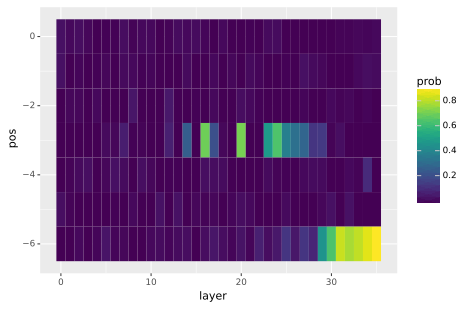

In [85]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = -df["pos"].astype(int)
df["prob"] = df["prob"].astype(float)

plot = (ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill="prob")))
print(plot)